<a href="https://colab.research.google.com/github/Karthik433-collab/ShadowFox/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define indices of classes to keep (airplane: 0, car: 1, frog: 6, horse: 7)
classes_to_keep = [0, 1, 6, 7]  # airplane, car, frog, horse
train_mask = np.isin(y_train, classes_to_keep).flatten()
test_mask = np.isin(y_test, classes_to_keep).flatten()

# Filter the dataset
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

# Map the labels to new indices (0 to 3)
label_mapping = {0: 0, 1: 1, 6: 2, 7: 3}  # airplane:0, car:1, frog:2, horse:3
y_train_filtered = np.array([label_mapping[label[0]] for label in y_train_filtered])
y_test_filtered = np.array([label_mapping[label[0]] for label in y_test_filtered])

# Balance the dataset by sampling equal numbers of images per class
samples_per_class_train = 3000  # Increased to 3,000 per class
samples_per_class_test = 600    # Increased to 600 per class
x_train_balanced = []
y_train_balanced = []
x_test_balanced = []
y_test_balanced = []

for cls in range(4):
    train_indices = np.where(y_train_filtered == cls)[0]
    test_indices = np.where(y_test_filtered == cls)[0]

    # Sample training data
    if len(train_indices) > samples_per_class_train:
        train_indices = np.random.choice(train_indices, samples_per_class_train, replace=False)
    x_train_balanced.append(x_train_filtered[train_indices])
    y_train_balanced.append(y_train_filtered[train_indices])

    # Sample test data
    if len(test_indices) > samples_per_class_test:
        test_indices = np.random.choice(test_indices, samples_per_class_test, replace=False)
    x_test_balanced.append(x_test_filtered[test_indices])
    y_test_balanced.append(y_test_filtered[test_indices])

# Concatenate the balanced data
x_train_balanced = np.concatenate(x_train_balanced)
y_train_balanced = np.concatenate(y_train_balanced)
x_test_balanced = np.concatenate(x_test_balanced)
y_test_balanced = np.concatenate(y_test_balanced)

# Normalize pixel values
x_train_balanced = x_train_balanced / 255.0
x_test_balanced = x_test_balanced / 255.0
y_train_balanced = to_categorical(y_train_balanced, 4)
y_test_balanced = to_categorical(y_test_balanced, 4)

# Enhanced data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Increased shift range
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2,  # Added zoom
    fill_mode='nearest'
)
datagen.fit(x_train_balanced)

# Build the CNN model with batch normalization
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with data augmentation
history = model.fit(datagen.flow(x_train_balanced, y_train_balanced, batch_size=32),
                    epochs=50,  # Increased epochs for better training
                    validation_data=(x_test_balanced, y_test_balanced),
                    callbacks=[lr_scheduler])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test_balanced, y_test_balanced)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Save the model
model.save('image_tagging_model.h5')

# Define class names for the remaining classes
class_names = ['airplane', 'car', 'frog', 'horse']

# Prediction function with improved image quality in display
def predict_and_show(image_path, threshold=0.7):
    # Load the original image for display
    img_display = Image.open(image_path).convert('RGB')

    # Load and resize a copy of the image to 32x32 for model prediction
    img_for_model = img_display.resize((32, 32))
    img_array = np.array(img_for_model) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    max_prob = np.max(prediction)
    if max_prob < threshold:
        predicted_class = "unrecognized"
        confidence = max_prob * 100
    else:
        class_idx = np.argmax(prediction)
        predicted_class = class_names[class_idx]
        confidence = max_prob * 100

    # Display the original image (or resized to a larger size for better quality)
    plt.figure(figsize=(5, 5))  # Set figure size for better visibility
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f}%)")
    plt.show()
    return predicted_class

# Upload and predict on an image
uploaded = files.upload()
for file_name in uploaded.keys():
    predicted_class = predict_and_show(file_name)
    print(f"Predicted class for {file_name}: {predicted_class}")

Saving Screenshot 2025-06-03 175942.png to Screenshot 2025-06-03 175942 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


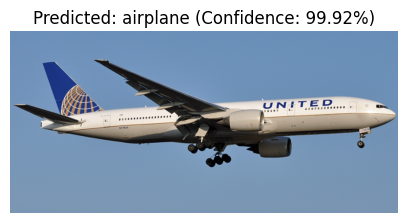

Predicted class for Screenshot 2025-06-03 175942 (2).png: airplane


In [35]:
uploaded = files.upload()
for file_name in uploaded.keys():
    predicted_class = predict_and_show(file_name)
    print(f"Predicted class for {file_name}: {predicted_class}")